<a href="https://colab.research.google.com/github/cadam57/ECM_DDEFI_2526_Cours1/blob/main/Sripts/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ce script sert à entrainer notre modèle et à l'utiliser s'il est déjà entrainé


In [2]:
#ce bloc sert à installer les packages python dont nous avons besoin
!pip install pandas numpy scikit-learn matplotlib

In [3]:
#dans ce bloc, nous installons les différentes bibliothèques dont nous aurons besoin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

from sklearn.neighbors import KernelDensity

In [4]:
# cette fonction calcule l'aire d'une zone rectangulaire en fonction des coordonnées des bords
#lat1, lat2, lon1 et lon2 sont respectivement les latitudes et longitudes des côtés de la zone observée.
#la fonction renvoit une aire en km2

def area(lat1, lat2, lon1, lon2, R = 6378):
    lat1 = np.pi * lat1 / 180.0
    lat2 = np.pi * lat2 / 180.0
    lon1 = np.pi * lon1 / 180.0
    lon2 = np.pi * lon2 / 180.0

    h = max(np.sin(lat1), np.sin(lat2)) - min(np.sin(lat1), np.sin(lat2))
    r = (max(lon1, lon2) - min(lon1,lon2)) / (2 * np.pi)

    return 2 * np.pi * (R ** 2) * h * r

print(area(41.644818,42.022548,-87.904123,-87.525759))
#-->le rectangle couvert par les données est de 1319.5307651175892km2, soit environ 2 fois l'air de chicago. Si on regarde une carte de la ville, on voit que le plus petit
#rectangle contenant la ville peut la contenir à peu près 2 fois, donc a priori la fonction calculant l'aire en fonction des coordonnées fonctionne bien.

1319.5307651175892


In [5]:
#ce bloc permet d'importer la base de donnée propre
url = "https://raw.githubusercontent.com/lejejefr/ECM_2526_FinalProject/refs/heads/main/Data/CleanData.csv"
df = pd.read_csv(url)
#la ligne suivante sert uniquement à vérifier que la base de données a bien été importée
df.describe()
#-->

,ID,time,day of week,day of year,latitude,longitude
count,1.394000e+04,13940.000000,13940.000000,13940.00000,13937.000000,13937.000000
mean,8.288289e+04,44380.933931,3.230273,190.47231,41.817290,-87.668187
std,8.602471e+05,27943.989010,2.061345,97.01024,0.078640,0.057413
min,6.340000e+02,0.000000,0.000000,1.00000,41.644818,-87.904123
25%,4.157750e+03,15780.000000,1.000000,115.75000,41.757257,-87.714760
50%,2.178050e+04,48600.000000,3.000000,192.00000,41.803585,-87.665192
75%,2.541325e+04,69960.000000,5.000000,268.00000,41.880778,-87.624568
max,1.373461e+07,86340.000000,6.000000,366.00000,42.022548,-87.525759


In [6]:
len(df)
#-->13940

13940

Dans cette partie, on a essayé de mettre en place une random forest pour évaluer le nombre de meutres au voisinage du point étudié


In [7]:
#ce bloc permet de générer des données labélisées utilisables pour l'entraînement et le test
min_lat = 41.644818
max_lat = 42.022548

min_long = -87.904123
max_long = -87.525759

min_time = 0.0
max_time = 86340.0

space_division = 50
time_division = 24

latitude_span = (max_lat - min_lat) / space_division
longitude_span = (max_long - min_long) / space_division
time_span = (max_time - min_time) / time_division

def calculate_density(row):
  lat_center = row["latitude"]
  lon_center = row["longitude"]
  time_center = row["time"]
  dow = row["day of week"]
  doy = row["day of year"]

  lat_min_zone = max(lat_center - latitude_span/2, min_lat)
  lat_max_zone = min(lat_center + latitude_span/2, max_lat)

  lon_min_zone = max(lon_center - longitude_span/2, min_long)
  lon_max_zone = min(lon_center + longitude_span/2, max_long)

  time_min_zone = max(time_center - time_span/2, min_time)
  time_max_zone = min(time_center + time_span/2, max_time)
  subset = df[
      (df["latitude"].between(lat_min_zone, lat_max_zone)) &
      (df["longitude"].between(lon_min_zone, lon_max_zone)) &
      (df["time"].between(time_min_zone, time_max_zone))
      #(df["day of week"] == dow) &
      #(df["day of year"] == doy)
      ]
  count = len(subset)
  volume = ((time_max_zone - time_min_zone) / 3600) * area(lat_min_zone,lat_max_zone,lon_min_zone,lon_max_zone)
  if volume <= 0.00001:
    return 0
  return count




labeled_df = pd.DataFrame({
    "latitude": np.random.uniform(min_lat, max_lat, 15000),
    "longitude": np.random.uniform(min_long, max_long, 15000),
    "time": np.random.uniform(0.000000, 86340.000000, 15000),
    "day of week": np.random.randint(0, 6, 15000),
    "day of year": np.random.randint(1, 366, 15000),
})
labeled_df["density"] = labeled_df.apply(calculate_density, axis = 1)

labeled_df.describe()

,latitude,longitude,time,day of week,day of year,density
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,41.833778,-87.715823,43275.871720,2.477467,183.151400,0.231333
std,0.108569,0.109607,25029.357481,1.711088,105.289771,0.752588
min,41.644821,-87.904118,0.147140,0.000000,1.000000,0.000000
25%,41.740762,-87.810916,21516.644270,1.000000,92.000000,0.000000
50%,41.833729,-87.715634,43244.095750,2.000000,184.000000,0.000000
75%,41.926330,-87.619634,65407.546594,4.000000,274.000000,0.000000
max,42.022537,-87.525774,86339.223252,5.000000,365.000000,10.000000


In [8]:
labeled_df.describe()

,latitude,longitude,time,day of week,day of year,density
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,41.833778,-87.715823,43275.871720,2.477467,183.151400,0.231333
std,0.108569,0.109607,25029.357481,1.711088,105.289771,0.752588
min,41.644821,-87.904118,0.147140,0.000000,1.000000,0.000000
25%,41.740762,-87.810916,21516.644270,1.000000,92.000000,0.000000
50%,41.833729,-87.715634,43244.095750,2.000000,184.000000,0.000000
75%,41.926330,-87.619634,65407.546594,4.000000,274.000000,0.000000
max,42.022537,-87.525774,86339.223252,5.000000,365.000000,10.000000


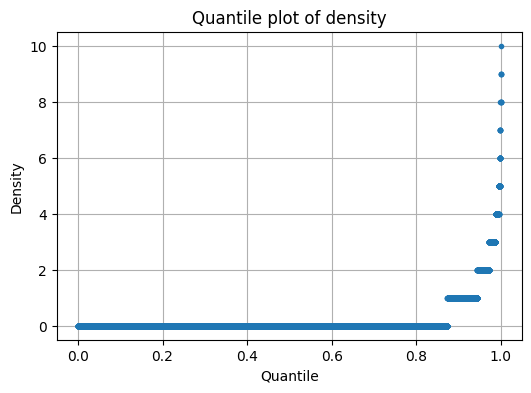

In [9]:
# Trier les données
sorted_density = np.sort(labeled_df["density"])

# Calculer les quantiles (0 à 1)
quantiles = np.arange(1, len(sorted_density)+1) / len(sorted_density)

# Plot
plt.figure(figsize=(6,4))
plt.plot(quantiles, sorted_density, marker='.', linestyle='none')
plt.xlabel("Quantile")
plt.ylabel("Density")
plt.title("Quantile plot of density")
plt.grid(True)
plt.show()

In [10]:
#lat_bin = pd.cut(labeled_df["latitude"], bins=10, labels=False)
#lon_bin = pd.cut(labeled_df["longitude"], bins=10, labels=False)
#time_bin = pd.cut(labeled_df["time"], bins=6, labels=False)

density_bin = pd.cut(labeled_df["density"], bins=3, labels=False)

#strat = lat_bin.astype(str) + "_" + lon_bin.astype(str) + "_" + time_bin.astype(str) + "_" + density_bin.astype(str)

X = labeled_df.drop('density',axis = 1)
Y = labeled_df['density']

print(len(X))
print(len(Y))
print(len(density_bin))

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.2,
    random_state=42,
    stratify=None
)
print(X_train.describe())
print(X_test.describe())
print(Y_train.describe())
print(Y_test.describe())

15000
15000
15000
           latitude     longitude          time   day of week   day of year
count  12000.000000  12000.000000  12000.000000  12000.000000  12000.000000
mean      41.832847    -87.715528  43261.056811      2.480167    182.516000
std        0.108542      0.109151  24960.156324      1.715571    105.740835
min       41.644821    -87.904118      7.754951      0.000000      1.000000
25%       41.739357    -87.809958  21557.135619      1.000000     89.750000
50%       41.833177    -87.715012  43236.662145      2.000000    183.500000
75%       41.924752    -87.620269  65292.061305      4.000000    275.000000
max       42.022537    -87.525801  86332.943759      5.000000    365.000000
          latitude    longitude          time  day of week  day of year
count  3000.000000  3000.000000   3000.000000  3000.000000  3000.000000
mean     41.837501   -87.717003  43335.131353     2.466667   185.693000
std       0.108616     0.111422  25308.378582     1.693274   103.444222
min      4

In [11]:
rf = RandomForestRegressor()
rf.fit(X_train,Y_train)

RandomForestRegressor()

In [12]:
Y_pred = rf.predict(X_test)
print(Y_pred)

[0.   0.   0.   ... 0.14 0.01 0.  ]


In [13]:
prediction_dataframe = pd.DataFrame({
    'prediction': Y_pred
})

error_df = pd.DataFrame()
print(Y_test.describe())
error_df["error"] = (Y_pred - Y_test)**2
print(error_df.describe())

count    3000.000000
mean        0.209000
std         0.706271
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         8.000000
Name: density, dtype: float64
             error
count  3000.000000
mean      0.321514
std       1.532037
min       0.000000
25%       0.000000
50%       0.000000
75%       0.044100
max      45.427600


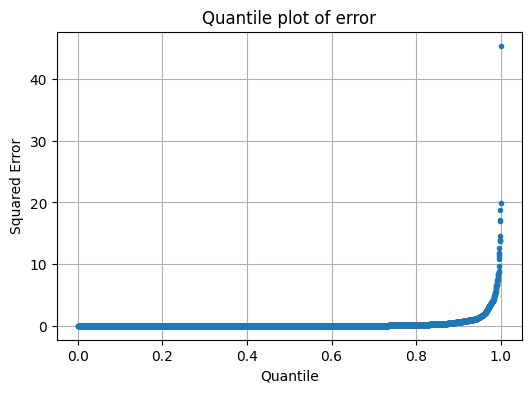

In [14]:
# Trier les données
sorted_error = np.sort(error_df["error"])

# Calculer les quantiles (0 à 1)
quantiles = np.arange(1, len(sorted_error)+1) / len(sorted_error)

# Plot
plt.figure(figsize=(6,4))
plt.plot(quantiles, sorted_error, marker='.', linestyle='none')
plt.xlabel("Quantile")
plt.ylabel("Squared Error")
plt.title("Quantile plot of error")
plt.grid(True)
plt.show()

In [15]:
accuracy = mean_squared_error(Y_test,Y_pred)
print(accuracy)

0.32151376666666664


# **K_means clustering**

Dans cette partie, nous avons mis en place différents modèles KDE pour évaluer la densité de probabilité qui correspond à notre distribution

In [16]:
# bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
import sklearn

In [18]:
#ce bloc permet d'importer la base de donnée propre
url = "https://raw.githubusercontent.com/lejejefr/ECM_2526_FinalProject/refs/heads/main/Data/CleanData.csv"
df = pd.read_csv(url)
#la ligne suivante sert uniquement à vérifier que la base de données a bien été importée
df.describe()

,ID,time,day of week,day of year,latitude,longitude
count,1.394000e+04,13940.000000,13940.000000,13940.00000,13937.000000,13937.000000
mean,8.288289e+04,44380.933931,3.230273,190.47231,41.817290,-87.668187
std,8.602471e+05,27943.989010,2.061345,97.01024,0.078640,0.057413
min,6.340000e+02,0.000000,0.000000,1.00000,41.644818,-87.904123
25%,4.157750e+03,15780.000000,1.000000,115.75000,41.757257,-87.714760
50%,2.178050e+04,48600.000000,3.000000,192.00000,41.803585,-87.665192
75%,2.541325e+04,69960.000000,5.000000,268.00000,41.880778,-87.624568
max,1.373461e+07,86340.000000,6.000000,366.00000,42.022548,-87.525759


In [19]:
df.head()

,ID,time,day of week,day of year,latitude,longitude
0,28910,62340,0,279,41.750334,-87.665045
1,28909,62100,0,279,41.880968,-87.737940
2,28908,33420,0,279,41.882208,-87.767204
3,28907,12960,0,279,41.821964,-87.690298
4,28906,74100,5,277,41.866235,-87.720517


<Axes: xlabel='longitude', ylabel='latitude'>

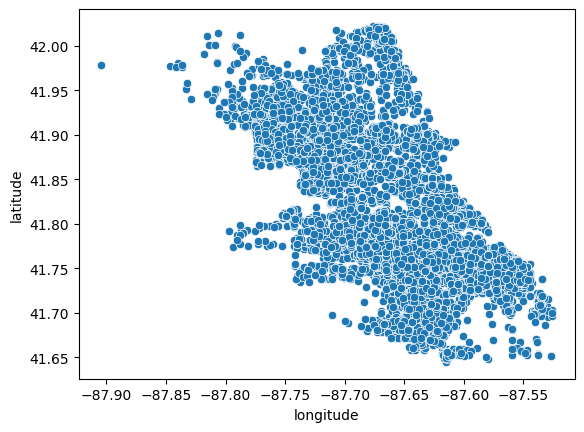

In [20]:

sns.scatterplot(data = df, x = 'longitude', y = 'latitude')
# on reconnaît la forme de chicago

In [ ]:
# étape facultative de projection des coordonnées dans système métrique

# import geopandas as gpd
# from shapely.geometry import Point

# gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")
# # projeter dans un CRS métrique adapté (ex: EPSG:26971 ou EPSG:3857 selon dispo)
# gdf = gdf.to_crs("EPSG:3857")  # TODO : choisis un CRS métrique adapté
# # Extraire X, Y en mètres
# gdf['x'] = gdf.geometry.x
# gdf['y'] = gdf.geometry.y


In [21]:
#etape de normalisation, facultative (à ajouter qd on prendra en compte la variable temps)

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# XY = scaler.fit_transform(gdf[['x','y']])


NameError: name 'gdf' is not defined

In [22]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# On sélectionne les variables latitude et longitude
X = df[['latitude', 'longitude']]

In [26]:
df.isna().sum()

,0
ID,0
time,0
day of week,0
day of year,0
latitude,3
longitude,3


In [31]:
df.dropna(inplace=True)
df.isna().sum()

,0
ID,0
time,0
day of week,0
day of year,0
latitude,0
longitude,0


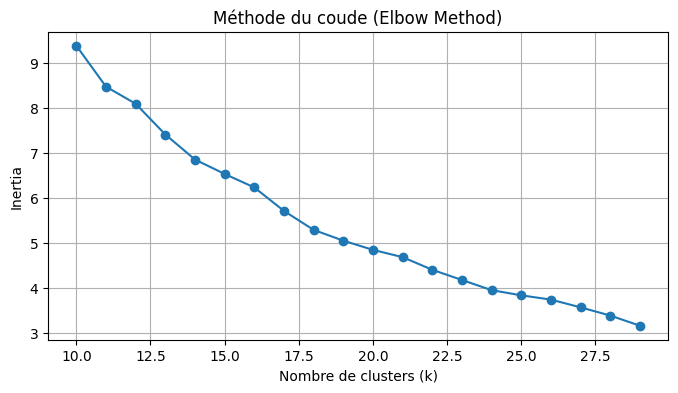

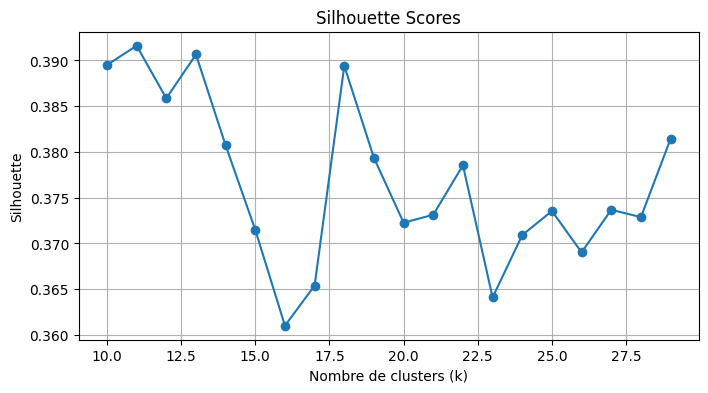

In [33]:
# CHOIX DU K

# cette partie sert à tracer 2 graphes qui vont nous aider à déterminer le nombre de clusters k
# on ne s'attend pas à trouver un k très bien adapté car on sait déjà que cet algorithme n'est pas le bon

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# On sélectionne les variables latitude et longitude
X = df[['latitude', 'longitude']]

# Tester plusieurs valeurs de k
k_values = range(10, 30)
inertia_scores = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)

    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, labels))

# ----- Plot du Elbow -----
# on trace l'inertie = variance interne aux clusters en fonction de k
# le k optimal se trouve au niveau du "coude" du graphe
plt.figure(figsize=(8,4))
plt.plot(k_values, inertia_scores, marker='o')
plt.title("Méthode du coude (Elbow Method)")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

# ----- Plot du Silhouette -----
# on cherche k pour lequel le silhouette score est maximal
plt.figure(figsize=(8,4))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Scores")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette")
plt.grid(True)
plt.show()


In [40]:
k_final = 13   #pcq on a rien trouvé de mieux, cf les plots précédents

kmeans = KMeans(n_clusters=k_final, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Les centres des clusters
centroids = kmeans.cluster_centers_

print("Centroides lat/lon :")
print(centroids)


Centroides lat/lon :
[[ 4.19011562e+01 -8.77606437e+01  1.62536651e-13]
 [ 4.17581932e+01 -8.76105234e+01  1.00000000e+01]
 [ 4.18651031e+01 -8.77164675e+01  4.00000000e+00]
 [ 4.17566469e+01 -8.75700864e+01  7.00000000e+00]
 [ 4.17174601e+01 -8.75580197e+01  1.10000000e+01]
 [ 4.16881035e+01 -8.76292799e+01  3.00000000e+00]
 [ 4.17904229e+01 -8.76608213e+01  1.00000000e+00]
 [ 4.17493040e+01 -8.76550944e+01  1.20000000e+01]
 [ 4.19096340e+01 -8.77151772e+01  8.00000000e+00]
 [ 4.18123006e+01 -8.76204482e+01  9.00000000e+00]
 [ 4.17892727e+01 -8.77054807e+01  6.00000000e+00]
 [ 4.18787596e+01 -8.76538875e+01  2.00000000e+00]
 [ 4.19815097e+01 -8.76806355e+01  5.00000000e+00]]


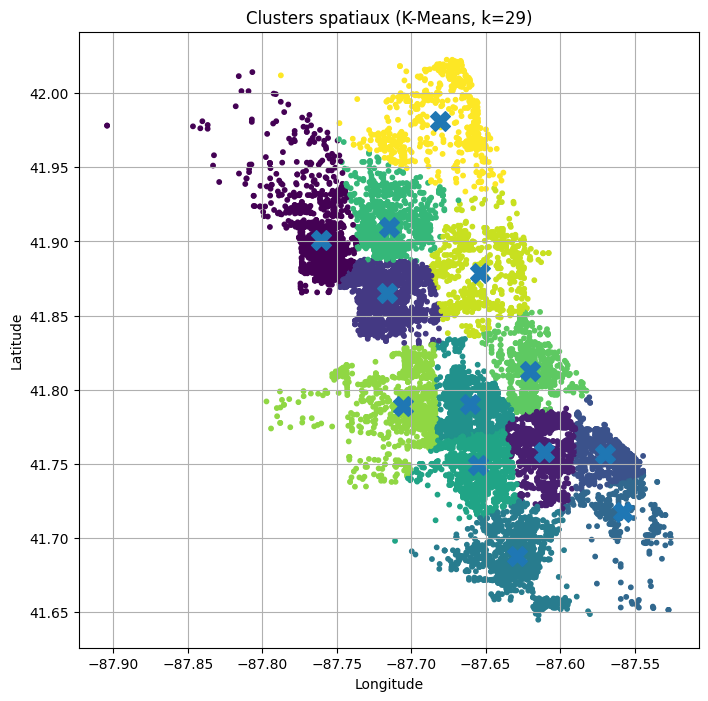

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(
    df['longitude'],
    df['latitude'],
    c=df['cluster'],
    s=10
)

# On ajoute les centroïdes
plt.scatter(
    centroids[:,1],  # longitude
    centroids[:,0],  # latitude
    s=200,
    marker='X'
)

plt.title(f"Clusters spatiaux (K-Means, k={k})")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()
